In [1]:
#importing all the necessary libraries for the assignment
import pandas as pd
import numpy as np
from scipy import interp
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize, LabelEncoder
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

np.seterr(over="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Data preparation and processing


In [37]:
#reading dataset into a pandas data frame data, separating on the spaces (\s+), transposing the data so that the
#rows and columns have switched positions
data = pd.read_csv("hazelnuts.txt", sep="\s+", header=None, engine="python").transpose()

#naming each of the columns in the data frame with the correct header
data.columns = ["sample_id", "length", "width", "thickness", "surface_area", "mass", "compactness", "hardness",
                          "shell_top_radius", "water_content", "carbohydrate_content", "variety"]

#creating a labelEncoder object
le = LabelEncoder()
data["variety"] = le.fit_transform(data["variety"])

#removing the sample id and variety columns from the predictor columns
columns = data.columns.tolist()[1:-1]

#converting the predictor columns to type float
data[columns] = data[columns].apply(lambda col:col.astype(float))

#normalizing the predictor columns
normalized = data[columns].apply(lambda x: x/x.max())

#passing data["variety"] to normalized["variety"] so that all columns are of type variety
normalized["variety"] = data["variety"]

#converting the dataframe to numpy arrays
#Y being the prediction variable converted to integers
Y = normalized.to_numpy()[:,-1].astype(int)
#X being the predictors
X = normalized.to_numpy()[:,:-1]

#using scikit learn's test train split on the dataset to split the data into training set equal to 2/3's of the 
#data and testing set of the remaing 1/3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 13)

In [78]:
np.insert(X_test[5],0,1)

array([1.        , 0.58429907, 0.80808331, 0.77518342, 0.69357885,
       0.84      , 0.9581836 , 0.4004432 , 0.79679389, 0.95926729,
       0.94857143])

## Regression model

In [139]:
# Regression model class to contain all the functions relating to the algorithm. 
class LogRegression:
    # The constructor for the class. Takes in parameters for learning rate, maximum number of iterations, and tolerance
    def __init__(self, lr=0.3, maxIter=50000, threshold = 0.5):
        self.lr = lr
        self.maxIter = maxIter
        self.threshold = threshold
    # The sigmoid function, which returns probability values between 0 and 1.
    def sigmoid(self, X, T):
        return 1 / (1 + np.exp(np.array(-np.dot(X, T),dtype=np.float32)))
    
    # Add intercept for matrix multiplication
    def intercept(self, X):
        try:
            return np.insert(X, 0, 1, axis=1)
        except:
            return [np.insert(X, 0, 1)]
        
    # Compute cost
    def cost(self, y, y_pred):
        m = Y.shape[0]
        cost = (1/m) * -(np.sum(np.multiply(np.log(y_pred), y) + np.multiply((1-y), np.log(1-y_pred))))
        return cost

    def fit(self, X, y, show_cost = True):          
        
        X = self.intercept(X)           
        # Initialize weights to 0. X.shape returns the dimensions of the training matrix, and index[1] gets the number of features
        n_features = X.shape[1]       
        
        # For multinomial logistic regression. Array containing each output class
        self.classes = np.unique(y)
        self.weights = []
        
        # iterate through each class
        for c in self.classes:  
            # Mark instances of class c in Y vector 1, and other classes 0
            binary_y = np.where(y == c, 1, 0)      
            # Initialize theta values.
            theta = np.zeros(n_features)  
            # Update weights untill convergence
            for i in range(self.maxIter):
                # Create a hypothesis from initial theta values. This will be used to calculate error
                h = self.sigmoid(X, theta)
                
                # Calculate the error between class predictions from the hypothesis and actual class labels 
                delta = (np.dot(X.T,(h-binary_y)))           
                # Update coefficients
                theta = theta - ((self.lr/X.shape[0]) * delta)        
                
                if show_cost and i%1000 == 0:
                    print(f"Cost after {i} iterations:", np.round(self.cost(binary_y, h), 2))
                    
                # Stop converging if the delta reaches a tolerance threshold
                if np.all(np.less(abs(delta), self.threshold)):
                    break
            print("Weight set training complete.")
            # Appends weights for each iteration to global set
            self.weights.append(theta) 
        print("Training complete.")
            
    # Takes in a numpy array of values and returns the predicted class for each set of inputs
    def predict(self, X):
        # adds intercept
        X = self.intercept(X)
        # Loop through the input set and finds the coefficients that yield the maximum probability for a set
        # Returns the index of the set of coefficiets from the global weight array as that coincides with the class
        return np.array([np.argmax([self.sigmoid(i, theta) for theta in self.weights]) for i in X]).astype(int)

    # Returns an array of probability sets for each set of input values
    def predict_prob(self, X):
        X = self.intercept(X)
        # Holds all sets
        all_probabilities = []    
        # Loop through X array
        for i in X:
            # Hold probabilities for the input set
            probabilities = [] 
            # Loop through coefficients and append their corresponding probabilities to an array
            for theta in self.weights:
                probabilities.append(self.sigmoid(i, theta))
            # When all coefficient probabilities are gathered, append those as an array to all probabilities
            all_probabilities.append(probabilities)     
        return np.array(all_probabilities).astype(float)
    
    def predict_class(self, oclass):
        return le.inverse_transform(self.predict(oclass))


#creating an object of the LogRegression model
lr = LogRegression(lr = 0.2, maxIter = 10000, threshold = 0.3)
#fitting it the training portion of the dataset
lr.fit(X_train,y_train)   
            

Cost after 0 iterations: 0.62
Cost after 1000 iterations: 0.44
Cost after 2000 iterations: 0.41
Cost after 3000 iterations: 0.39
Cost after 4000 iterations: 0.38
Cost after 5000 iterations: 0.37
Cost after 6000 iterations: 0.37
Cost after 7000 iterations: 0.36
Cost after 8000 iterations: 0.35
Cost after 9000 iterations: 0.35
Weight set training complete.
Cost after 0 iterations: 0.62
Cost after 1000 iterations: 0.27
Cost after 2000 iterations: 0.23
Cost after 3000 iterations: 0.21
Cost after 4000 iterations: 0.2
Cost after 5000 iterations: 0.2
Cost after 6000 iterations: 0.19
Cost after 7000 iterations: 0.19
Cost after 8000 iterations: 0.18
Cost after 9000 iterations: 0.18
Weight set training complete.
Cost after 0 iterations: 0.62
Cost after 1000 iterations: 0.29
Cost after 2000 iterations: 0.24
Cost after 3000 iterations: 0.22
Cost after 4000 iterations: 0.21
Cost after 5000 iterations: 0.21
Cost after 6000 iterations: 0.2
Cost after 7000 iterations: 0.2
Weight set training complete.

In [136]:
#Scikit Learn Model

#creating scikit learn logistic regression model for comparison to own implementation, setting parameters to 
#allow for a multiclass model, utilizinf the lbfgs algorithm, setting it to a max number of 10,000 interations
#and passing in the random state 13 so that the test train split in the dataset is the same throughout the assignment
logisticRegr = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, random_state=13)

#fitting the model
logisticRegr.fit(X_train, y_train)

#predicting category of hazelnut from the test predictors 
sk_y_pred = logisticRegr.predict(X_test)

#printing the accuracy of the model created calling scikit learn's accuracy_score on the actual and predicted results
print("Accuracy Score - Scikit Implementation:", accuracy_score(y_test, sk_y_pred))

Accuracy Score - Scikit Implementation: 0.95


In [137]:
#Own Implementation Model

#predicting the class of hazelnut using the test predictor
lr_y_pred = lr.predict(X_test)


#printing accuracy of own implementation
print("Accuracy Score - Own Implementation:", accuracy_score(y_test, lr_y_pred))

Accuracy Score - Own Implementation: 0.9


# Classification Reports

In [143]:
#Jenny
#Printing out our own implementation's model classification report
print("Classification Report - Own Implementation")
print(classification_report(y_test,lr_y_pred), "\n")

#Printing out the scikit learn model's classification report
print("Classification Report - Scikit Learn")
print(classification_report(y_test,sk_y_pred))

Classification Report - Own Implementation
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       1.00      0.75      0.86         4
           2       0.89      1.00      0.94         8

    accuracy                           0.90        20
   macro avg       0.92      0.88      0.89        20
weighted avg       0.91      0.90      0.90        20
 

Classification Report - Scikit Learn
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         8

    accuracy                           0.95        20
   macro avg       0.96      0.92      0.93        20
weighted avg       0.96      0.95      0.95        20



# Confusion Matrices

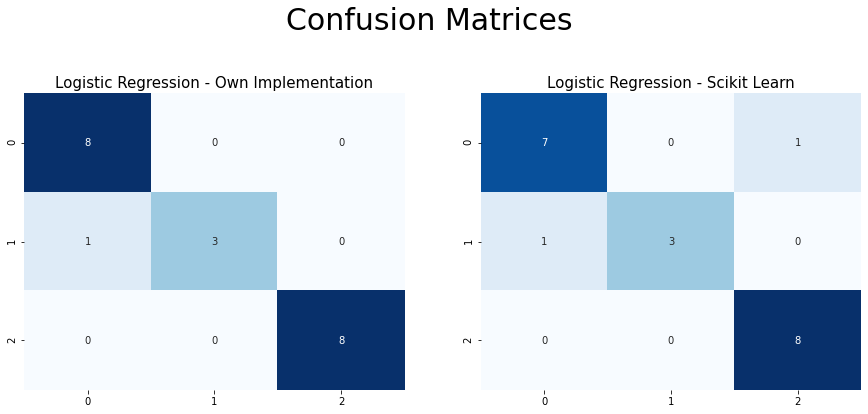

In [144]:
#Karolis
#Plotting the results of the confusion matrices side by side using 
#matplotlib and seaborn's heatmap
plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=30)

plt.subplot(2,2,1)
plt.title("Logistic Regression - Own Implementation", fontsize = 15)
cm = confusion_matrix(y_test,sk_y_pred)
sns.heatmap(cm, annot = True, cmap="Blues",cbar=False);

plt.subplot(2,2,2)
plt.title("Logistic Regression - Scikit Learn", fontsize = 15)
sck_cm = confusion_matrix(y_test,lr_y_pred)
sns.heatmap(sck_cm, annot = True, cmap="Blues",cbar=False);

## K Fold Cross Validation
Used own method for k-fold cross validation on dataset, utilising scikit learn's KFold function to split the data training and test sets 10 different ways.

In [140]:
#Own Implementation
#creating a KFold object that splits the dataset normalized 10 times
kf = KFold(n_splits=10, shuffle=True, random_state = 13)

lr = LogRegression(lr=0.05, threshold=2)
#creating an empty array scores to hold the accuracy scores of each model
scores = []

#using a for loop to iterate through the normalized dataset which is split 10 different ways
for train_index, test_index in kf.split(normalized):
    
    #splitting the dataset into it's training set and converting it from a dataframe to a numpy array using .values
    X_train = normalized.iloc[train_index][columns].values
    y_train = normalized.iloc[train_index]['variety'].values

    #splitting the dataset into it's testing set and also converting it to a numpy array
    X_test = normalized.iloc[test_index][columns].values
    y_test = normalized.iloc[test_index]['variety'].values
    
    #fitting the model on the training data
    lr.fit(X_train, y_train, show_cost = False)
    
    #predicting the class of the hazelnuts based on the predictor values in X_test
    y_pred = np.array(lr.predict(X_test))
    
    #appending the accuracy scores to the scores array
    scores.append(accuracy_score(y_test, y_pred))

#printing the array of scores
print("Score From Each Fold: ", scores)
#printing the average accuracy of the logistic regression model after 10 fold cross validation
print("Average K-Fold Score :" , np.mean(scores))


Weight set training complete.
Weight set training complete.
Weight set training complete.
Training complete.
Weight set training complete.
Weight set training complete.
Weight set training complete.
Training complete.
Weight set training complete.
Weight set training complete.
Weight set training complete.
Training complete.
Weight set training complete.
Weight set training complete.
Weight set training complete.
Training complete.
Weight set training complete.
Weight set training complete.
Weight set training complete.
Training complete.
Weight set training complete.
Weight set training complete.
Weight set training complete.
Training complete.
Weight set training complete.
Weight set training complete.
Weight set training complete.
Training complete.
Weight set training complete.
Weight set training complete.
Weight set training complete.
Training complete.
Weight set training complete.
Weight set training complete.
Weight set training complete.
Training complete.
Weight set training

In [141]:
#Scikit Learn Model
scores = []
for train_index, test_index in kf.split(normalized):
    X_train = normalized.iloc[train_index][columns].values
    y_train = normalized.iloc[train_index]['variety'].values

    X_test = normalized.iloc[test_index][columns].values
    y_test = normalized.iloc[test_index]['variety'].values
    
    logisticRegr.fit(X_train, y_train)
    y_pred = np.array(logisticRegr.predict(X_test))
    scores.append(accuracy_score(y_test, y_pred))
    
print('Scores from each Iteration: ', scores)
print('Average K-Fold Score :' , np.mean(scores))

Scores from each Iteration:  [0.7619047619047619, 0.9, 0.9, 0.85, 0.8, 0.9, 0.8, 0.9, 0.95, 0.95]
Average K-Fold Score : 0.8711904761904762


## ROC Curves

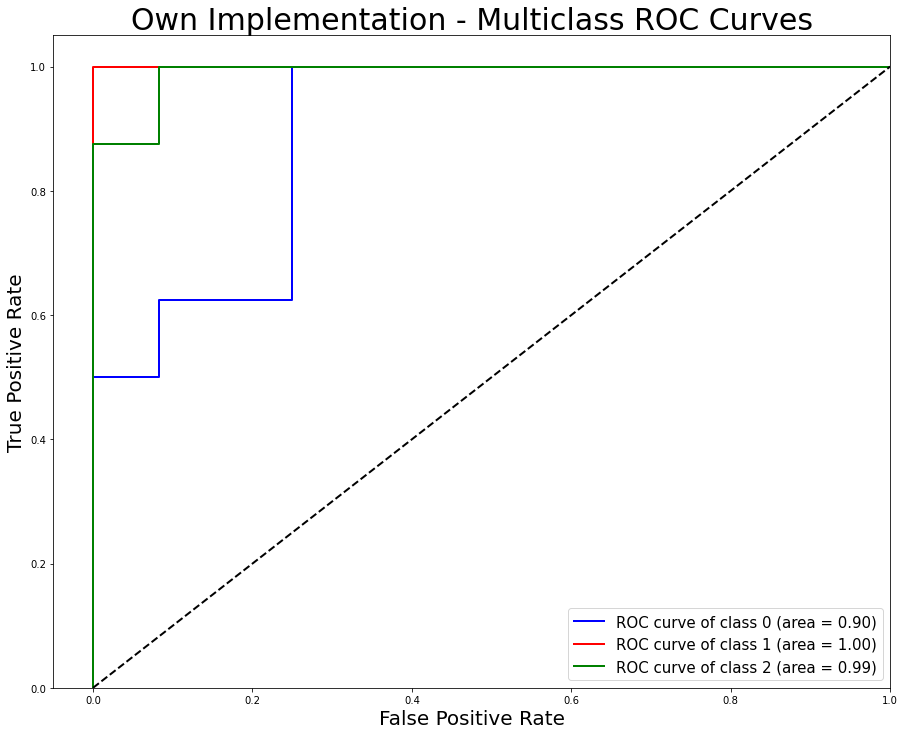

c:\users\ktiju\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


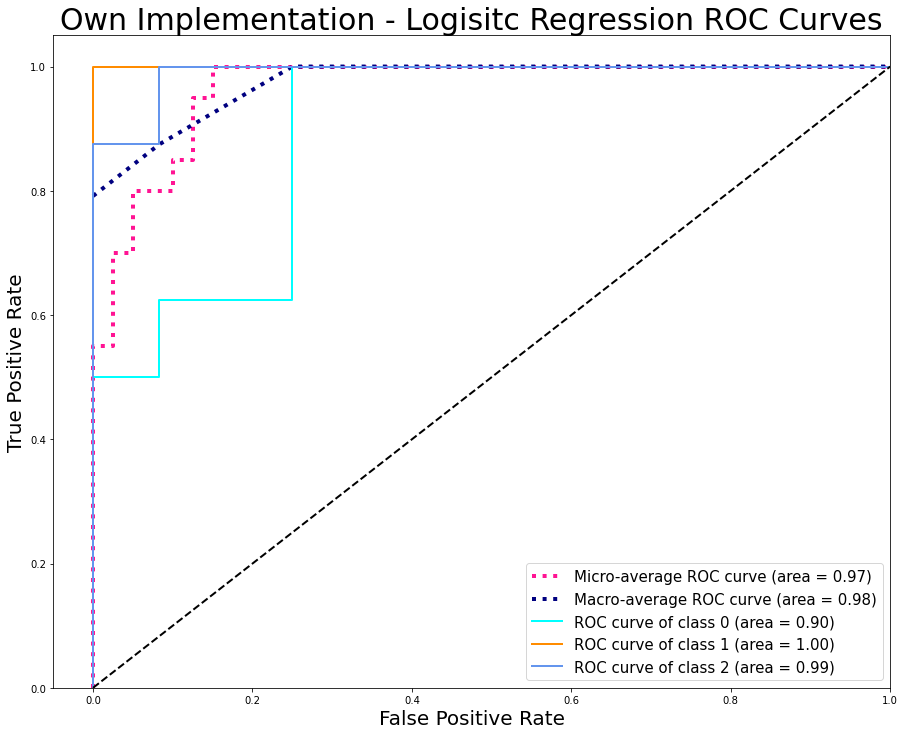

In [142]:
#Own Implementation
#*utilizing scikit learn's ROC example to aid plotting the multiclass ROC curves as outlined in their documentation at
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

#predicting the probability that a hazelnut belongs in a given class
y_pred_prob = lr.predict_prob(X_test)

#binarizing the actual class result using scikit learn's label_binarize() on the 3 classes as scikit learn's roc values
#can only be plotted in one class vs the others for multiclass models
y_test_bi = label_binarize(y_test, classes=[0,1,2])

#setting the number of classes variable to number of classes in the binarized prediction classes
n_classes = y_test_bi.shape[1]

#setting line width to 2
lw = 2

#creating dictionaries to store false positive rate (fpr), true positive rate (tpr) and roc area under the curve values
fpr_lr = dict()
tpr_lr = dict()
roc_auc_lr = dict()

#setting the plot size
plt.figure(figsize=(15,12))

#traversing the given number of classes
for i in range(n_classes):
    #producing fpr and tpr for the given iteration from scikit learn's roc_curve function
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_bi[:,i], y_pred_prob[:,i])
    #predicting area under the curve of the ROC
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

#iterating through an array of RGB colours    
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    #plotting the false positive rate vs the true positive rate for each class
    plt.plot(fpr_lr[i], tpr_lr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_lr[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Own Implementation - Multiclass ROC Curves', fontsize = 30)
plt.legend(loc="lower right", fontsize = 15)
plt.show() 

#Computing micro-average ROC curve and ROC area
fpr_lr["micro"], tpr_lr["micro"], _ = roc_curve(y_test_bi.ravel(), y_pred_prob.ravel())

#assigning the fpr and tpr micro-average values to variable for comparing models
fpr_lro = fpr_lr["micro"]
tpr_lro = tpr_lr["micro"]
roc_auc_lr["micro"] = auc(fpr_lr["micro"], tpr_lr["micro"])
roc_auc_lro = roc_auc_lr["micro"]

#aggregating all the false positive values in a numpy array
all_fpr_lr = np.unique(np.concatenate([fpr_lr[i] for i in range(n_classes)]))

#calling interp to interpolate all the values of fpr and tpr
mean_tpr_lr = np.zeros_like(all_fpr_lr)
for i in range(n_classes):
    mean_tpr_lr += interp(all_fpr_lr, fpr_lr[i], tpr_lr[i])

#computing the average value for the macro average by dividing the mean tpr by the number of classes
mean_tpr_lr /= n_classes

#assigning the macro values
fpr_lr["macro"] = all_fpr_lr
tpr_lr["macro"] = mean_tpr_lr
roc_auc_lr["macro"] = auc(fpr_lr["macro"], tpr_lr["macro"])

#Plotting all ROC Curves in one plot
plt.figure(figsize=(15,12))
#plotting the micro average ROC curve
plt.plot(fpr_lr["micro"], tpr_lr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_lr["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

#plotting the macro average ROC curve
plt.plot(fpr_lr["macro"], tpr_lr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_lr["macro"]),
         color='navy', linestyle=':', linewidth=4)

#plotting each of the class ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_lr[i], tpr_lr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_lr[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Own Implementation - Logisitc Regression ROC Curves', fontsize = 30)
plt.legend(loc="lower right", fontsize = 15)
plt.show()

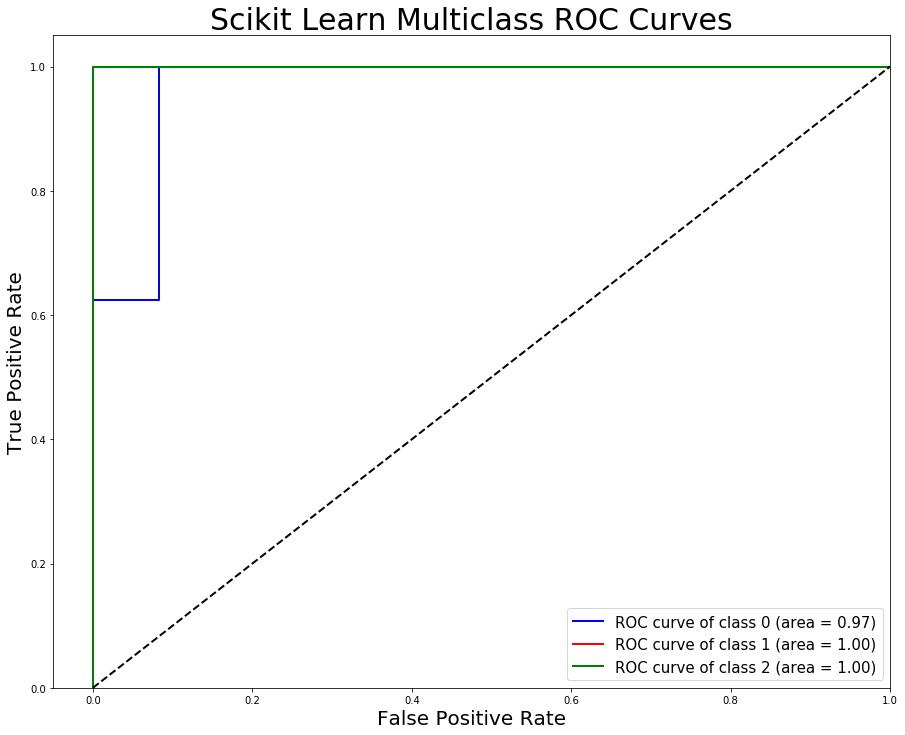

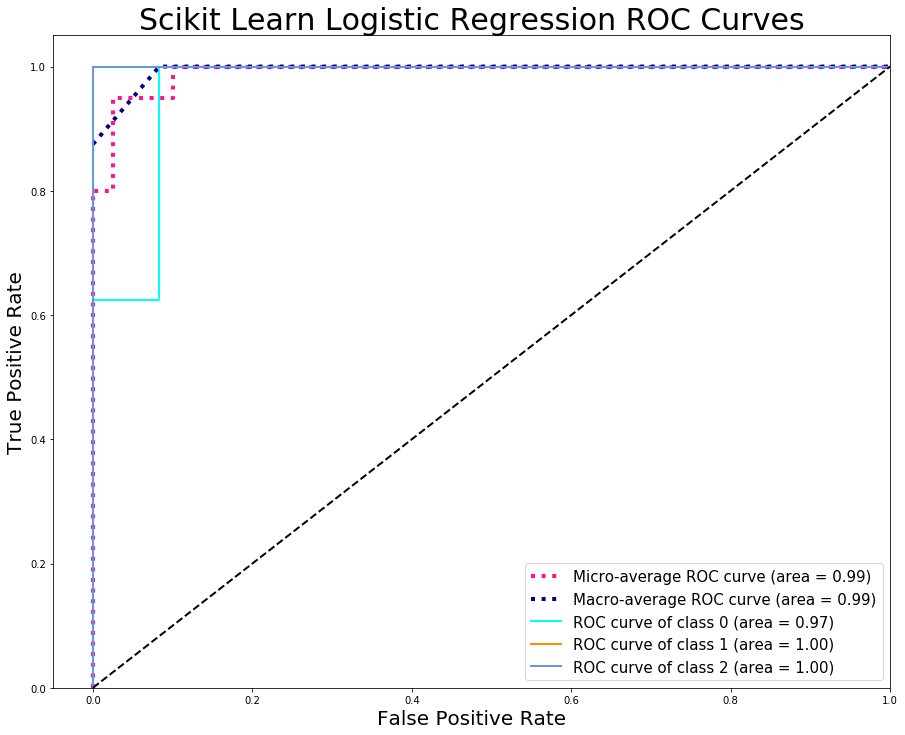

In [12]:
#Scikit Learn Model ROC Curves

#binarizing the test classes and setting n_classes to the number of classes in the test class
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]

#using scikit learn's predict_proba on the test predictors to return an array of probalities of 
#the likelihood that the hazelnut belongs to a given class based on it's predictor values
y_proba = logisticRegr.predict_proba(X_test)

#Computing ROC curve and ROC area under the curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(15,12))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Scikit Learn Multiclass ROC Curves', fontsize=30)
plt.legend(loc="lower right", fontsize = 15)
plt.show()

# Micro and macro averages of the ROC curves
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_proba.ravel())
sk_fpr = fpr["micro"]
sk_tpr_avg = tpr["micro"]
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
sk_roc_auc_avg = roc_auc["micro"]


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#Plotting all ROC curves in the one plot
plt.figure(figsize=(15,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Scikit Learn Logistic Regression ROC Curves', fontsize=30)
plt.legend(loc="lower right", fontsize = 15)
plt.show()

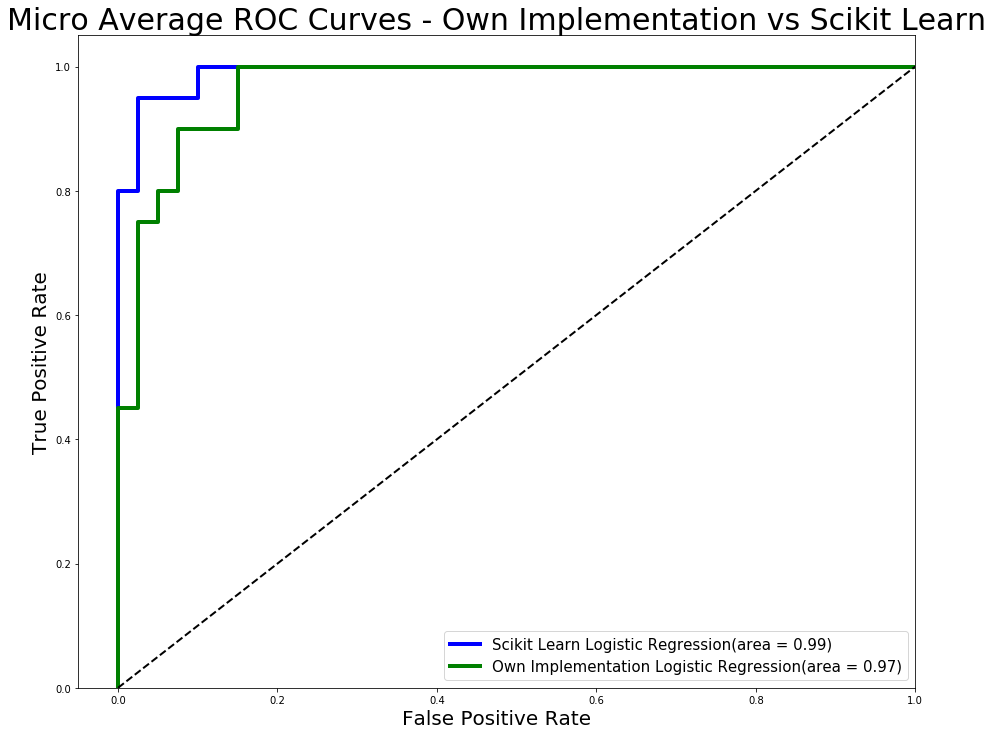

In [13]:
#Plotting the ROC curves of the two model's against one another
plt.figure(figsize=(15,12))
plt.plot(sk_fpr, sk_tpr_avg, label='Scikit Learn Logistic Regression(area = {0:0.2f})'''.format(sk_roc_auc_avg), color = 'blue', linewidth=4)
plt.plot(fpr_lro, tpr_lro,label='Own Implementation Logistic Regression(area = {0:0.2f})'''.format(roc_auc_lro), color = 'green', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Micro Average ROC Curves - Own Implementation vs Scikit Learn', fontsize = 30)
plt.legend(loc="lower right", fontsize = 15)
plt.show()